In [1]:
# general purpose libraries
import numpy as np
import numpy.linalg as lg
from matplotlib import pyplot as plt

# orthogonal polynomials
from scipy.special import jacobi

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def scalar_product(f, g, a, b, stepcount=1000):
    p = lambda x: f(x)*g(x)
    xp = np.linspace(start=a, stop=b, num=stepcount, endpoint=True)    
    return np.trapz(p(xp), xp)

def d_dx(f, eps=0.0001):
    return lambda x: (f(x+eps) - f(x))/eps

def d2_dx2(f, eps=0.0001):
    return lambda x: d_dx(d_dx(f, eps), eps)(x)

In [3]:
def solve_bvp_squaremin(A, f, a, b, generate_phi, n=5):        
    G = np.ndarray((n, n,), dtype=np.float_)
    for i in range(n):
        for j in range(n):
            pi, dpi_dx, d2pi_dx2 = generate_phi(i)
            pj, dpj_dx, d2pj_dx2 = generate_phi(j)
            Api = A(pi, dpi_dx, d2pi_dx2)
            Apj = A(pj, dpj_dx, d2pj_dx2)
            G[i][j] = scalar_product(Api, Apj, a, b)

    d = np.ndarray((n,), dtype=np.float_)
    for i in range(n):
        pi, dpi_dx, d2pi_dx2 = generate_phi(i)
        Api = A(pi, dpi_dx, d2pi_dx2)
        d[i] = scalar_product(f, Api, a, b)
        
    c = lg.solve(G, d)        
    def v(x):
        value = 0.
        for i in range(n):
            p, dp_dx, d2p_dx2 = generate_phi(i)
            value += c[i]*p(x)
        return value
    
    return v

def solve_bvp_galerkin(A, f, a, b, generate_phi, n=5):
    G = np.ndarray((n, n,), dtype=np.float_)
    for i in range(n):
        for j in range(n):
            pi, dpi_dx, d2pi_dx2 = generate_phi(i)
            pj, dpj_dx, d2pj_dx2 = generate_phi(j)            
            Apj = A(pj, dpj_dx, d2pj_dx2)
            G[i][j] = scalar_product(pi, Apj, a, b)

    d = np.ndarray((n,), dtype=np.float_)
    for i in range(n):
        pi, dpi_dx, d2pi_dx2 = generate_phi(i)        
        d[i] = scalar_product(f, pi, a, b)
        
    c = lg.solve(G, d)        
    def v(x):
        value = 0.
        for i in range(n):
            p, dp_dx, d2p_dx2 = generate_phi(i)
            value += c[i]*p(x)
        return value
    
    return v

In [13]:
# Initializing the variables
m1, m2, m3, m4, m5 = 10, 9, 1, 1, 7
k1, k2, k3 = 1, 2, 1
p1, p2, p3 = 4, 1, 3
q1, q2, q3 = 1, 2, 1
alpha1, alpha2 = 1, 1
a, b = -1, 1

u = lambda x: m1*sin(m2*x) + m3*cos(m4*x) + m5
k = lambda x: k1*cos(k2*x) + k3
p = lambda x: p1*cos(p2*x) + p3
q = lambda x: q1*cos(q2*x) + q3

du_dx = lambda x: d_dx(u, 0.000001)(x)#-m1*m2*sin(m2*x) - m3*m4*sin(m4*x)
d2u_dx2 = lambda x: d2_dx2(u, 0.000001)(x)#-m2*m2*m2*cos(m2*x) - m3*m4*m4*cos(m4*x)
dk_dx = lambda x: -k1*k2*sin(k2*x)

bound_a = lambda v, dv_dx: -k(a)*dv_dx(a) + alpha1*v(a)
bound_b = lambda v, dv_dx: k(b)*dv_dx(b) + alpha2*v(b)

# differential operator
A = lambda v, dv_dx, d2v_dx2: lambda x: -(dk_dx(x) * dv_dx(x)) - (k(x) * d2v_dx2(x)) + p(x) * dv_dx(x) + q(x) * v(x)
f = lambda x: A(u, du_dx, d2u_dx2)(x)

# boundary values
mu1 = bound_a(u, du_dx)
mu2 = bound_b(u, du_dx)

In [17]:
# pre-processing the input
A_ = -(alpha2*mu1 - alpha1*mu2)/(alpha2*alpha1*(b-a) + alpha2*k(a) + alpha1*k(b))
B_ = (-a*alpha1*mu2 + b*alpha2*mu1 + k(a)*mu2 + mu1*k(b))/(alpha2*alpha1*(b-a) + alpha2*k(a) + alpha1*k(b))
psi = lambda x: A_*x + B_
dpsi_dx = lambda x: A_
d2psi_dx2 = lambda x: 0
f_ = lambda x: f(x) - A(psi, dpsi_dx, d2psi_dx2)(x)

# creating a orthogonal polynomials
D_ = (k(a)*(b-a)*(b-3*a) - alpha1*((a-b)**2)*a)/(-k(a)*(b-a)*2 - alpha1*((a-b)**2))
C_ = ( - k(b)*(a-b)*(a-3*b) - alpha2*((b-a)**2)*b)/(k(b)*(a-b)*2 - alpha2*((b-a)**2))

def phi_generator(i):
    if i == 0:
        phi = lambda x: ((x-a)**2) * (x - C_)
        dphi_dx = lambda x: (a-x)*(a + 2*C_ - 3*x)
        d2phi_dx2 = lambda x: -2*(2*a + C_ - 3*x)
        return phi, dphi_dx, d2phi_dx2
    if i == 1:
        phi = lambda x: ((x-b)**2) * (x - D_)
        dphi_dx = lambda x: (b-x)*(b + 2*D_ - 3*x)
        d2phi_dx2 = lambda x: -2*(2*b + D_ - 3*x)
        return phi, dphi_dx, d2phi_dx2       
    if i >= 2:        
        phi = lambda x: ((x-a)**i) * ((x-b)**2)
        dphi_dx = lambda x: i*((x-b)**2)*((x-a)**(i-1)) + 2*(x-b)*((x-a)**i)
        d2phi_dx2 = lambda x: (i-1)*i*((x-b)**2)*((x-a)**(i-2)) + 4*i*(x-b)*((x-a)**(i-1)) + 2*((x-a)**i)
        return phi, dphi_dx, d2phi_dx2

# solve
sol_ms = solve_bvp_squaremin(A, f_, a, b, phi_generator, 10)
sol_gl = solve_bvp_galerkin(A, f_, a, b, phi_generator, 10)
solution_ms = lambda x: sol_ms(x) + psi(x)
solution_gl = lambda x: sol_gl(x) + psi(x)

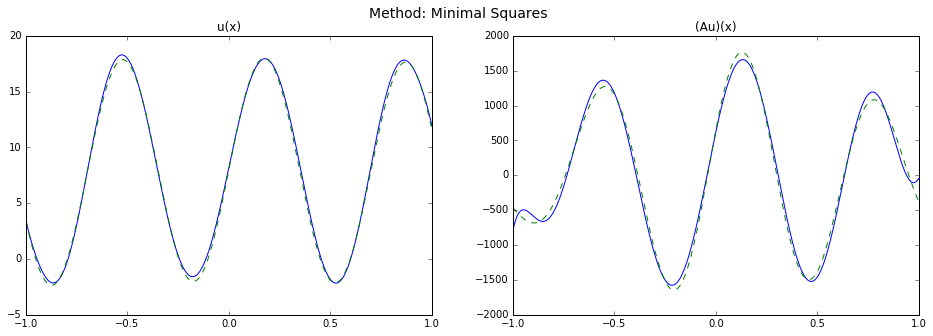

In [18]:
figure(num=None, figsize=(16, 5), dpi=80, facecolor='w', edgecolor='k')

plt.suptitle('Method: Minimal Squares', size=14)

xplot = np.linspace(a, b, 1000, True)
xpoints = np.linspace(a, b, 1000, True)
ysol = solution_ms(xplot)
yorig = u(xpoints)

plt.subplot(1, 2, 1)
plt.title('u(x)')
plt.plot(xplot, ysol)
plt.plot(xpoints, yorig, '--')

xplot = np.linspace(a, b, 1000, True)
xpoints = np.linspace(a, b, 1000, True)
Ap = A(u, du_dx, d2u_dx2)(xpoints)
As = A(solution_ms, d_dx(solution_ms), d2_dx2(solution_ms))(xplot)

plt.subplot(1, 2, 2)
plt.title('(Au)(x)')
plt.plot(xplot, As)
plt.plot(xpoints, Ap, '--')

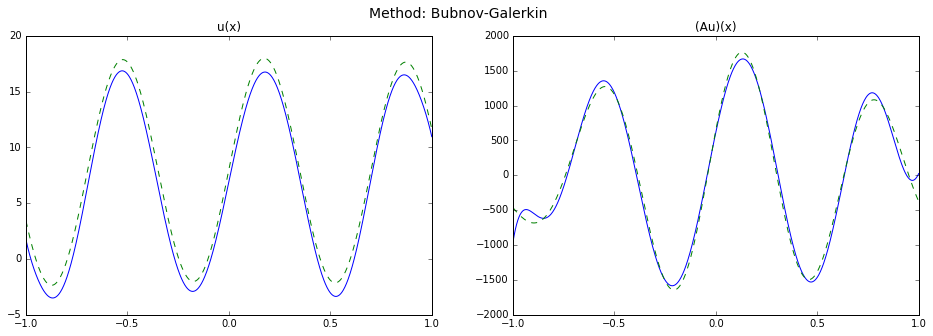

In [19]:
figure(num=None, figsize=(16, 5), dpi=80, facecolor='w', edgecolor='k')

plt.suptitle('Method: Bubnov-Galerkin', size=14)

xplot = np.linspace(a, b, 1000, True)
xpoints = np.linspace(a, b, 1000, True)
ysol = solution_gl(xplot)
yorig = u(xpoints)

plt.subplot(1, 2, 1)
plt.title('u(x)')
plt.plot(xplot, ysol)
plt.plot(xpoints, yorig, '--')

xplot = np.linspace(a, b, 1000, True)
xpoints = np.linspace(a, b, 1000, True)
Ap = A(u, du_dx, d2u_dx2)(xpoints)
As = A(solution_gl, d_dx(solution_gl), d2_dx2(solution_gl))(xplot)

plt.subplot(1, 2, 2)
plt.title('(Au)(x)')
plt.plot(xplot, As)
plt.plot(xpoints, Ap, '--')

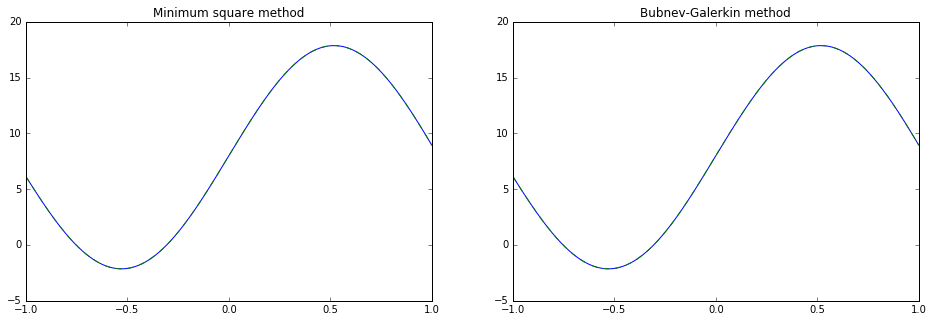

In [9]:
figure(num=None, figsize=(16, 5), dpi=80, facecolor='w', edgecolor='k')

xplot = np.linspace(a, b, 1000, True)
xpoints = np.linspace(a, b, 1000, True)
ysol = solution_gl(xplot)
yorig = u(xpoints)

plt.subplot(1, 2, 1)
plt.title('Minimum square method')
plt.plot(xplot, ysol)
plt.plot(xpoints, yorig, '--')

xplot = np.linspace(a, b, 1000, True)
xpoints = np.linspace(a, b, 1000, True)
ysol = solution_gl(xplot)
yorig = u(xpoints)

plt.subplot(1, 2, 2)
plt.title('Bubnev-Galerkin method')
plt.plot(xplot, ysol)
plt.plot(xpoints, yorig, '--')